## Accessing Neo4j DB from outside

In [7]:
from py2neo import Graph

remote_graph = Graph("http://ec2-52-56-99-123.eu-west-2.compute.amazonaws.com:7474/db/data/", user='neo4j', password='graphtest')

remote_graph

cypher_query = "MATCH (n:ARTICLE)-[r:CITES]->(k:ARTICLE) WHERE n.pmcid IN ['PMC3769458', 'PMC5890653', 'PMC4580396'] RETURN n, r, k;"

remote_graph.run(cypher_query)

In [1]:
import sys
sys.path.append('../backend/lib')
sys.path.append('../backend')
from GraphSession import GraphSession
from ResultGraph import ResultGraph
from networkx import generate_gml
import networkx as nx
from networkx.readwrite import json_graph
import json

search_input = "tourigny"#"campbell cancer leukemia" #"nlp genomics"
graphsession = GraphSession(search_input)
citations = graphsession.get_citations_from_fulltext_mongo(search_input, retmax=200)
resultGraph = ResultGraph()
resultGraph.populate_from_cite_dict(citations)
        
resultGraph.extract_by_connectivity(connectivity=1)
resultGraph.extract_by_connectivity(connectivity=0)
        
# Query metadata
metadataList = graphsession.get_metadataList_from_mongo(resultGraph.nodeIds)
resultGraph.add_metadata_to_graph(metadataList)
resultGraph.get_graph(graph_format='cytoscape')

07/23/2018 09:41:34 PM [INFO]: Created new log.
07/23/2018 09:41:35 PM [INFO]: RequestFullTextSearch: Creating request
07/23/2018 09:41:35 PM [INFO]: ConnectEutils: Connecting to eutils API:
 https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pmc&tool=graphsearch&sort=relevance&term=tourigny&retmax=200
07/23/2018 09:41:35 PM [INFO]: MongoSession: Mongo db connection successful
07/23/2018 09:41:36 PM [INFO]: MongoSession: Mongo db connection successful
07/23/2018 09:41:37 PM [INFO]: Max degree: 26


22


'{"graph": {"nodes": [{"data": {"node_col": "#ff7373", "journal": "Indian pacing and electrophysiology journal", "key": "20552060", "authors": "Udink Ten Cate, Wiesner, Trieschmann", "cite_color": "black", "id": "20552060", "group": "Cited", "name": "20552060", "pubDate": "Jun 2010", "title": "Dyssynchronous ventricular activation in asymptomatic wolff-Parkinson-white syndrome: a risk factor for development of dilated cardiomyopathy.", "label": "Indian pacing and electrophysiology journal", "journal_iso": "Indian Pacing Electrophysiol J"}}, {"data": {"node_col": "#ffd4d4", "journal": "Healthcare policy = Politiques de sante", "key": "23115575", "authors": "Breton, L\\u00e9vesque, Pineault", "cite_color": "black", "id": "23115575", "group": "Cited", "name": "23115575", "pubDate": "Nov 2011", "title": "Primary Care Reform: Can Quebec\'s Family Medicine Group Model Benefit from the Experience of Ontario\'s Family Health Teams?", "label": "Healthcare policy = Politiques de sante", "journal

In [1]:
import sys
sys.path.append('../backend/lib')
sys.path.append('../backend')
from GraphSession import GraphSession
from ResultGraph import ResultGraph
from networkx import generate_gml
import networkx as nx
from networkx.readwrite import json_graph
import json

search_input = "cancer"#"campbell cancer leukemia" #"nlp genomics"
graphsession = GraphSession(search_input)
pmc_hits = graphsession.get_pubmed_results_from_fulltext(search_input, retmax=20)

pmc_hits
pmc_lst = ["'PMC{0}'".format(pmc) for pmc in pmc_hits]
pmc_str = ', '.join(pmc_lst)
print len(pmc_lst)
print pmc_str

08/02/2018 11:35:35 AM [INFO]: Created new log.
08/02/2018 11:35:36 AM [INFO]: RequestFullTextSearch: Creating request
08/02/2018 11:35:36 AM [INFO]: ConnectEutils: Connecting to eutils API:
 https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pmc&tool=graphsearch&sort=relevance&term=cancer&retmax=20


20
'PMC5811185', 'PMC5473951', 'PMC4339370', 'PMC5850596', 'PMC5287060', 'PMC3921623', 'PMC5339024', 'PMC5434894', 'PMC3769458', 'PMC4588097', 'PMC4568174', 'PMC4580396', 'PMC4569005', 'PMC5890653', 'PMC3295744', 'PMC5421136', 'PMC3560853', 'PMC5570538', 'PMC4951023', 'PMC4819002'


In [6]:

cypher_query = 'MATCH (k:ARTICLE)-[r:CITES]->(n:ARTICLE { pmcid IN [' + pmc_str + '] })' + \
    'WITH k, r, n LIMIT 10 MATCH (n)-[r2:CITES]->(k2:ARTICLE) ' + \
    'MATCH (j1)-[p1:PUBLISHED]->(n) MATCH (j2)-[p2:PUBLISHED]->(k) ' + \
    'MATCH (j3)-[p3:PUBLISHED]->(k2) RETURN n, r, r2, k, k2, j1, j2, j3, p1, p2, p3;'

cypher_query3 = 'MATCH (k:ARTICLE)-[r:CITES]->(n:ARTICLE) WHERE n.pmcid IN [' + pmc_str + '] ' + \
    'MATCH (n)-[r2:CITES]->(k2:ARTICLE) ' + \
    'MATCH (j1:JOURNAL)-[p1:PUBLISHED]->(n) MATCH (j2)-[p2:PUBLISHED]->(k) ' + \
    'MATCH (j3:JOURNAL)-[p3:PUBLISHED]->(k2) RETURN n, r, r2, k, k2, j1, j2, j3, p1, p2, p3;'
    
cypher_query4 = 'MATCH (k:ARTICLE)-[r:CITES]->(n:ARTICLE) WITH k, r, n, size((k)-[:CITES]->(n)) as degree ' + \
    'WHERE n.pmcid IN [' + pmc_str + '] RETURN degree;' + \
    'MATCH (n)-[r2:CITES]->(k2:ARTICLE) ' + \
    'MATCH (j1:JOURNAL)-[p1:PUBLISHED]->(n) MATCH (j2)-[p2:PUBLISHED]->(k) ' + \
    'MATCH (j3:JOURNAL)-[p3:PUBLISHED]->(k2) RETURN n, r, r2, k, k2, j1, j2, j3, p1, p2, p3;'

cypher_query5 = 'MATCH (k:ARTICLE) WHERE k.pmcid IN [' + pmc_str + '] ' + \
    'WITH k, size(()-[:CITES]->(k)) as degree RETURN k, degree;'
    
cypher_query2 = 'MATCH (n:ARTICLE)-[k:CITES]->(r:ARTICLE) WHERE n.pmcid IN [' + pmc_str + '] '+ \
    'MATCH (j:JOURNAL)-[p:PUBLISHED]->(n) MATCH (j2:JOURNAL)-[p2:PUBLISHED]->(r) RETURN n,k,r,j,p,j2,p2;'

cypher_query6 = 'MATCH (k:ARTICLE)-[r:CITES]->(n:ARTICLE) WHERE n.pmcid IN [' + pmc_str + '] ' + \
    'MATCH (n)-[r2:CITES]->(k2:ARTICLE) RETURN n, r, r2, k, k2;'    

cypher_query7 = 'MATCH (n:ARTICLE)-[r:CITES]->(k:ARTICLE) WHERE n.pmcid IN [' + pmc_str + '] ' + \
    'RETURN count(n);'
#    'RETURN n, r, k;'
    
print cypher_query2



MATCH (n:ARTICLE)-[k:CITES]->(r:ARTICLE) WHERE n.pmcid IN ['PMC5811185', 'PMC5473951', 'PMC4339370', 'PMC5850596', 'PMC5287060', 'PMC3921623', 'PMC5339024', 'PMC5434894', 'PMC3769458', 'PMC4588097', 'PMC4568174', 'PMC4580396', 'PMC4569005', 'PMC5890653', 'PMC3295744', 'PMC5421136', 'PMC3560853', 'PMC5570538', 'PMC4951023', 'PMC4819002'] MATCH (j:JOURNAL)-[p:PUBLISHED]->(n) MATCH (j2:JOURNAL)-[p2:PUBLISHED]->(r) RETURN n,k,r,j,p,j2,p2;


Design Cypher query

MATCH (k:ARTICLE)-[r:CITES]->(n:ARTICLE) WHERE n.pmcid IN ['PMC2922830', 'PMC4799500', 'PMC3794158', 'PMC2214268', 'PMC2225401', 'PMC2193312', 'PMC2790177', 'PMC3330087', 'PMC3002699', 'PMC3002681', 'PMC3330072', 'PMC5884338', 'PMC4984747', 'PMC4500844', 'PMC3841715', 'PMC4176142', 'PMC3836249', 'PMC3590618', 'PMC3457162', 'PMC3079976'] WITH k, r, n LIMIT 10 MATCH (n)-[r2:CITES]->(k2:ARTICLE) MATCH (j1)-[p1:PUBLISHED]->(n) MATCH (j2)-[p2:PUBLISHED]->(k) MATCH (j3)-[p3:PUBLISHED]->(k2) RETURN n, r, r2, k, k2, j1, j2, j3, p1, p2, p3;

### Connecting to Neo4j and submitting query

In [5]:
import py2neo
from py2neo import Graph
import networkx as nx

graph = Graph(user='neo4j', password="graphtest")#, host="http://ec2-52-56-99-123.eu-west-2.compute.amazonaws.com:7474")

#cypher_query = "MATCH (n:ARTICLE)-[r:CITES]->(k:ARTICLE) WHERE n.pmcid IN ['PMC5811185', 'PMC5473951', 'PMC4339370', 'PMC5850596', 'PMC5287060', 'PMC3921623', 'PMC5339024', 'PMC5434894', 'PMC3769458', 'PMC4588097', 'PMC4568174', 'PMC4580396', 'PMC4569005', 'PMC5890653', 'PMC3295744', 'PMC5421136', 'PMC3560853', 'PMC5570538', 'PMC4951023', 'PMC4819002'] RETURN n, r, k;"
cypher_query = "MATCH (n:ARTICLE)-[r:CITES]->(k:ARTICLE) WHERE n.pmcid IN ['PMC3769458', 'PMC5890653', 'PMC4580396'] RETURN n, r, k;"
neo_request = graph.run(cypher_query)

#g = neo_request.to_subgraph()
#print g.relationships.

#for n in g.nodes:
#    print n
#    print n.identity
#    print dict(n)
#    attr = dict(n)
#    break
    
#for r in g.relationships:
#    print r
#    print dict(r)
#    break
    
neo_request.to_series()[0]

(_8904690:ARTICLE {authors: 'Fidler M M, Frobisher C, Guha J, Wong K, Kelly J, Winter D L, Sugden E, Duncan R, Whelan J, Reulen R C, Hawkins M M', journal: 'British journal of cancer', journal_iso: 'Br. J. Cancer', month: 'Jun', pmcid: 'PMC4580396', pmid: '25989269', title: 'Long-term adverse outcomes in survivors of childhood bone sarcoma: the British Childhood Cancer Survivor Study.', year: 2015})

In [14]:
r.start_node.identity

8904690

In [24]:
import networkx as nx
import py2neo
from py2neo import Graph


def neo2networkx(neo_subgraph):
    # Extract nodes and relationships from neo_subgraph
    nodes = neo_subgraph.nodes
    rels = neo_subgraph.relationships
    
    # Generate new NetworkX object
    G = nx.Graph()
    
    # Set up dictionary to map Neo4j IDs to PMID
    pmid_map = {}
    
    # Add all nodes
    for node in nodes:
        attr = dict(node)
        pmid = attr['pmid']
        neo_id = node.identity
        pmid_map[neo_id] = pmid
        
        #print node
        G.add_node(pmid)
        #break
        
    print pmid_map
    
    # Add relationships
    for rel in rels:
        start_node = pmid_map[rel.start_node.identity]
        end_node = pmid_map[rel.end_node.identity]
        G.add_edge(start_node, end_node)
        #break
        
    return G
    

graph = Graph(user='neo4j', password="graphtest")

#cypher_query = "MATCH (n:ARTICLE)-[r:CITES]->(k:ARTICLE) WHERE n.pmcid IN ['PMC5811185', 'PMC5473951', 'PMC4339370', 'PMC5850596', 'PMC5287060', 'PMC3921623', 'PMC5339024', 'PMC5434894', 'PMC3769458', 'PMC4588097', 'PMC4568174', 'PMC4580396', 'PMC4569005', 'PMC5890653', 'PMC3295744', 'PMC5421136', 'PMC3560853', 'PMC5570538', 'PMC4951023', 'PMC4819002'] RETURN n, r, k;"
cypher_query = "MATCH (n:ARTICLE)-[r:CITES]->(k:ARTICLE) WHERE n.pmcid IN ['PMC3769458', 'PMC5890653', 'PMC4580396'] RETURN n, r, k;"
neo_request = graph.run(cypher_query)

nx_graph = neo2networkx(neo_request.to_subgraph())
#g = neo_request.to_subgraph()
#g.nodes

nx.draw(nx_graph)

{4296069: u'16767717', 6642571: u'21642683', 6812302: u'21947833', 6068881: u'20447915', 645396: u'3469460', 4708513: u'17557301', 7591666: u'23401292', 4652464: u'17450524', 5004468: u'18268128', 6284730: u'20922787', 5927228: u'20107164', 6516542: u'21407221', 7638082: u'23484904', 3499333: u'15127411', 5144655: u'18521283', 5217484: u'18664655', 1478223: u'8614005', 3678291: u'15534610', 3289178: u'14506117', 6170191: u'20634481', 6166330: u'20628130', 8132400: u'24419490', 4491366: u'17141498', 5363942: u'19030995', 6470122: u'21319288', 5522289: u'19327986', 8904690: u'25989269', 6182206: u'20656964', 4821368: u'17849473', 1510009: u'8690526', 5524988: u'19332714'}


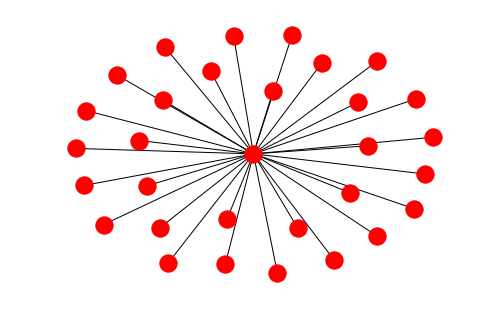

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
nx.draw(nx_graph)

## Try performing Neo4j query using module

In [ ]:
import sys
sys.path.append('../backend/lib')
sys.path.append('../backend')
from GraphDbConnector import NeoGraph
from GraphSession import GraphSession
import networkx as nx
from networkx.readwrite import json_graph
from FrontEndGraph import FrontEndGraph

# Get pmc hits
search_input = "cancer"#"campbell cancer leukemia" #"nlp genomics"
graphsession = GraphSession(search_input)
pmc_hits = graphsession.get_pubmed_results_from_fulltext(search_input, retmax=20)

# Perform Neo4j request
neo_graph = NeoGraph()

nx_graph = neo_graph.process_search_request(pmc_hits)

for node in nx_graph.nodes:
    print node
    break
    
#nx.get_node_attributes(nx_graph, 'group')

#json_graph.node_link_data(nx_graph)

frontendgraph = FrontEndGraph(nx_graph)
cy_json = frontendgraph.get_cyto_graph()

08/02/2018 05:51:06 PM [INFO]: Created new log.
08/02/2018 05:51:06 PM [INFO]: RequestFullTextSearch: Creating request
08/02/2018 05:51:06 PM [INFO]: ConnectEutils: Connecting to eutils API:
 https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pmc&tool=graphsearch&sort=relevance&term=cancer&retmax=20
08/02/2018 05:51:08 PM [INFO]: Max degree: 284


10594042
0
> /home/ubuntu/git/GraphSearch/backend/lib/FrontEndGraph.py(141)get_cyto_graph()
    137                         'target':edge['target'] }})
    138         cy_dict = {'stats': network_stats, 'graph': {'nodes': node_lst, 'edges': edge_lst}}
    139 
    140         from IPython.core.debugger import Tracer; Tracer()()
--> 141         return json.dumps(cy_dict)

ipdb> cy_dict['stats']
{'num_citations': 575, 'pub_years': {'values': [2000, 2009, 2007, 2012, 2012, 2006, 2010, 1999, 2011, 2008, 2012, 2011, 2002, 2006, 2015, 2012, 2009, 2012, 2010, 2002, 2012, 2006, 2011, 2003, 2004, 1997, 2011, 2008, 2004, 2009, 2006, 2003, 2011, 2006, 1998, 2008, 2012, 2012, 2011, 2012, 2009, 2004, 2003, 2012, 2001, 2006, 2004, 2000, 2009, 2011, 2004, 2007, 1994, 2010, 2011, 2007, 2011, 1987, 2010, 2011, 2004, 1999, 1995, 2011, 2012, 2011, 2011, 2003, 2006, 2011, 2011, 2009, 2011, 2011, 2011, 2001, 2002, 2012, 1999, 2010, 2012, 2008, 2011, 2011, 1992, 2005, 2010, 2011, 2013, 2007, 2003, 2010, 200

In [4]:
cy_json['graph']

TypeError: string indices must be integers, not str

In [ ]:
from networkx.readwrite import json_graph
import json

data = json_graph.node_link_data(resultGraph.G)
json.dump(data,open('output/demo_network_neo4j.json','w'),indent=2)

In [2]:
neo_graph.assign_search_group(pmc_hits = [])
neo_graph.nodeIds

[u'10594042',
 u'19211554',
 u'17220709',
 u'22419113',
 u'22412968',
 u'16541321',
 u'19755960',
 u'10088625',
 u'21280033',
 u'14981919',
 u'18202660',
 u'22487097',
 u'21116605',
 u'12395331',
 u'16391371',
 u'26147988',
 u'22262369',
 u'7745774',
 u'19718046',
 u'22421313',
 u'20107164',
 u'12153983',
 u'22120574',
 u'16114056',
 u'21227456',
 u'12917301',
 u'14618625',
 u'9308706',
 u'21499299',
 u'18443270',
 u'15306667',
 u'20055873',
 u'17035408',
 u'14512791',
 u'21922147',
 u'16729877',
 u'9486458',
 u'18268068',
 u'22498643',
 u'22286766',
 u'21917926',
 u'22180128',
 u'19640651',
 u'15128610',
 u'12714970',
 u'22465832',
 u'11604436',
 u'16456578',
 u'15342808',
 u'10749120',
 u'19690547',
 u'22137794',
 u'15127411',
 u'17084552',
 u'8117767',
 u'20113899',
 u'21392092',
 u'17671448',
 u'21640519',
 u'3469460',
 u'20578004',
 u'22087262',
 u'15164171',
 u'18521283',
 u'7666483',
 u'21778785',
 u'22541435',
 u'21334674',
 u'21396984',
 u'12490539',
 u'16987655',
 u'21415163'

In [3]:
x = 'Han Mingli, Wang Yimeng, Liu Manran, Bi Xiaokai, Bao Junjie, Zeng Ni, Zhu Zhikun, Mo Zhiqiang, Wu Chengyi, Chen Xin'

x.split(',')

['Han Mingli',
 ' Wang Yimeng',
 ' Liu Manran',
 ' Bi Xiaokai',
 ' Bao Junjie',
 ' Zeng Ni',
 ' Zhu Zhikun',
 ' Mo Zhiqiang',
 ' Wu Chengyi',
 ' Chen Xin']

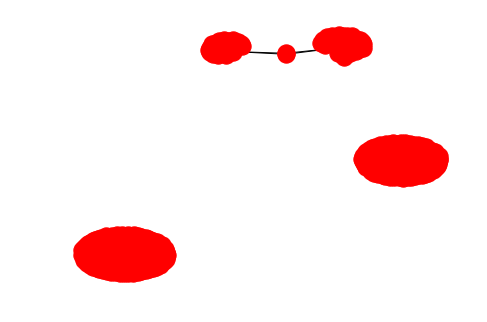

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline
nx.draw(nx_graph)